In [1]:
#model imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #to check stationarity
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose #for decomposing data
from statsmodels.tsa.arima.model import ARIMA #arima model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #plotting pacf & acf
import statsmodels.api as sm #sarima model
from sklearn.metrics import mean_squared_error #checking error 
from pmdarima.arima import auto_arima #finding optimum p&q values
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing data
data=pd.read_excel('DS3_C6_S4_TimeSeries_Sales_Data_Project.xls')
data.head(2)

Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   

  Customer Name   Segment        Country       City  ... Postal Code  Region  \
0   Claire Gute  Consumer  United States  Henderson  ...       42420   South   
1   Claire Gute  Consumer  United States  Henderson  ...       42420   South   

        Product ID   Category Sub-Category  \
0  FUR-BO-10001798  Furniture    Bookcases   
1  FUR-CH-10000454  Furniture       Chairs   

                                        Product Name   Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.96         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.94         3   

   Discount    Profit  
0       0.0   41.9136  
1       0.0  219.5820  

[2 rows x 21 columns]

## Data Preprocessing

In [3]:
data.shape #shape of data

(9994, 21)

In [4]:
data.columns #columns in data

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
data.dtypes #data types

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [6]:
data.isnull().sum() #checing for null values

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

There are no null values present in this data.

In [7]:
data['Category'].unique() #checking for unique category items

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [8]:
furniture_data=data[data['Category']=='Furniture'] #seperating furniture data

In [9]:
furniture_data['Sub-Category'].unique() #checking for unique furniture category items

array(['Bookcases', 'Chairs', 'Tables', 'Furnishings'], dtype=object)

In [10]:
#seperating furniture category items
bookcases_data=furniture_data[furniture_data['Sub-Category']=='Bookcases']
chairs_data=furniture_data[furniture_data['Sub-Category']=='Chairs']
tables_data=furniture_data[furniture_data['Sub-Category']=='Tables']
furnishings_data=furniture_data[furniture_data['Sub-Category']=='Furnishings']

In [11]:
#selecting date and sales column 
furniture_data1=furniture_data[['Order Date','Sales']]
bookcases_data1=bookcases_data[['Order Date','Sales']]
chairs_data1=chairs_data[['Order Date','Sales']]
tables_data1=tables_data[['Order Date','Sales']]
furnishings_data1=furnishings_data[['Order Date','Sales']]

In [12]:
#changing date as index
furniture_data2=furniture_data1.set_index('Order Date')
bookcases_data2=bookcases_data1.set_index('Order Date')
chairs_data2=chairs_data1.set_index('Order Date')
tables_data2=tables_data1.set_index('Order Date')
furnishings_data2=furnishings_data1.set_index('Order Date')

In [13]:
#resampling data to month wise and adding the sales
furniture=furniture_data2.resample('MS').sum()
bookcases=bookcases_data2.resample('MS').sum()
chairs=chairs_data2.resample('MS').sum()
tables=tables_data2.resample('MS').sum()
furnishings=furnishings_data2.resample('MS').sum()

## Exploratory Data Analysis

#### Furniture category wise sales

In [14]:
furnishing_sales1=pd.pivot_table(data=furniture_data,index='Sub-Category',values='Sales',aggfunc=sum).sort_values('Sales',ascending=False)
furnishing_sales1.reset_index(inplace=True)

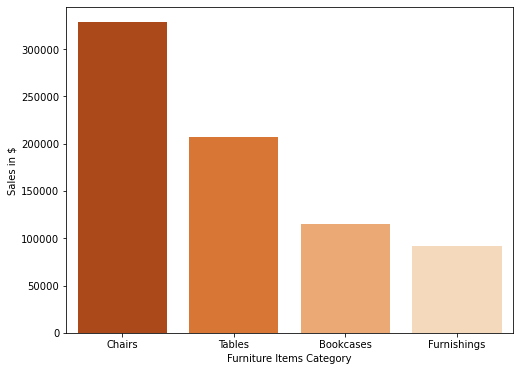

In [15]:
plt.figure(figsize=(8,6))
sns.barplot(x=furnishing_sales1['Sub-Category'],y=furnishing_sales1['Sales'],palette='Oranges_r')
plt.xlabel('Furniture Items Category')
plt.ylabel('Sales in $');

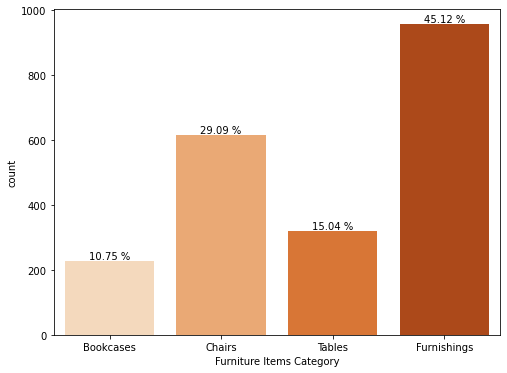

In [16]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(x = furniture_data['Sub-Category'], ax = ax,palette='Oranges')
plt.xlabel('Furniture Items Category')
for bar in ax.patches:                                                  
    percentage = f"{round((bar.get_height() /furniture_data.shape[0])*100 , 2)} %"  
    x = bar.get_x() + bar.get_width() /2                               
    y = bar.get_height()                                               
    ax.annotate(percentage, (x, y), va= "bottom", ha = "center" ) 

From the plot we can see furnishing items are highly sold.

#### Distribution of sales

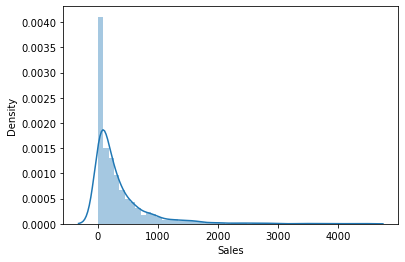

In [17]:
sns.distplot(furniture_data['Sales']);

From this plot we can see a right skewed distribution of sales.

In [18]:
profile=ProfileReport(furniture_data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Decomposing data

In [19]:
#function for decomposing data
def decompose(data,period=int):
    decomp=seasonal_decompose(data,period=period)
    trend=decomp.trend
    seasonal=decomp.seasonal
    residual=decomp.resid
    return(trend,seasonal,residual)

In [20]:
trend1,seasonal1,residual1=decompose(furniture,12)
trend2,seasonal2,residual2=decompose(bookcases,12)
trend3,seasonal3,residual3=decompose(chairs,12)
trend4,seasonal4,residual4=decompose(tables,12)
trend5,seasonal5,residual5=decompose(furnishings,12)

#### Visualizing decomposed data

In [21]:
#function for visualizing decomposed data
def decompose_show(data,trend,seasonal,residual,name='data'):
    plt.figure(figsize=(9,9))
    plt.subplot(4,1,1)
    plt.plot(data,label=name,color='orange')
    plt.legend()
    plt.subplot(4,1,2)
    plt.plot(trend,label='Trend',color='green')
    plt.legend()
    plt.subplot(4,1,3)
    plt.plot(seasonal,label='Seasonal',color='black')
    plt.legend()
    plt.subplot(4,1,4)
    plt.plot(residual,label='Noise',color='red')
    plt.legend();

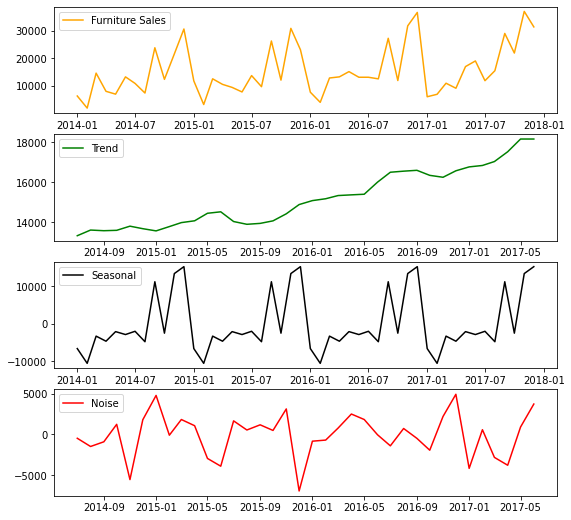

In [22]:
decompose_show(furniture,trend1,seasonal1,residual1,"Furniture Sales")

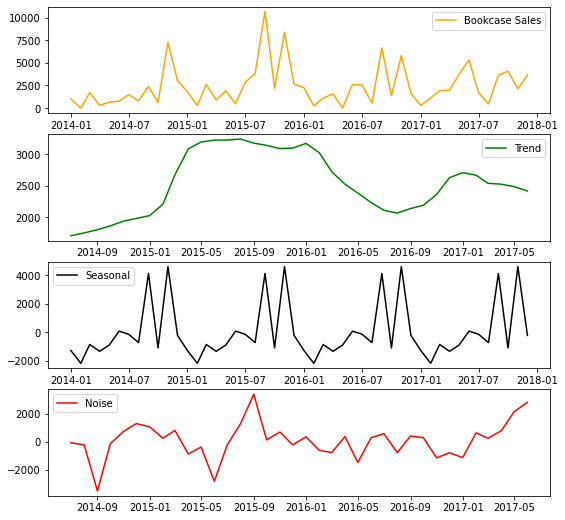

In [23]:
decompose_show(bookcases,trend2,seasonal2,residual2,"Bookcase Sales")

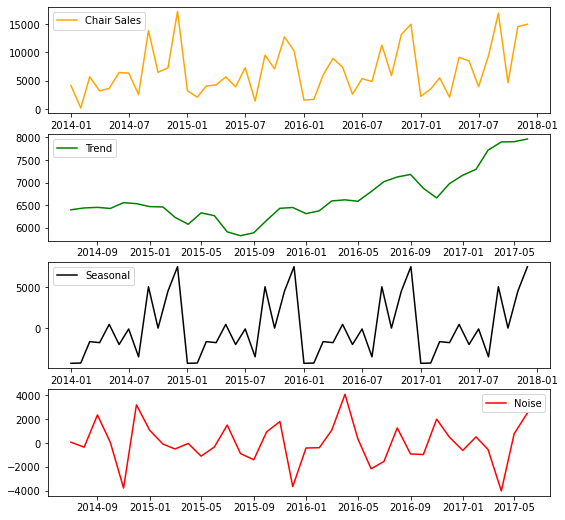

In [24]:
decompose_show(chairs,trend3,seasonal3,residual3,"Chair Sales")

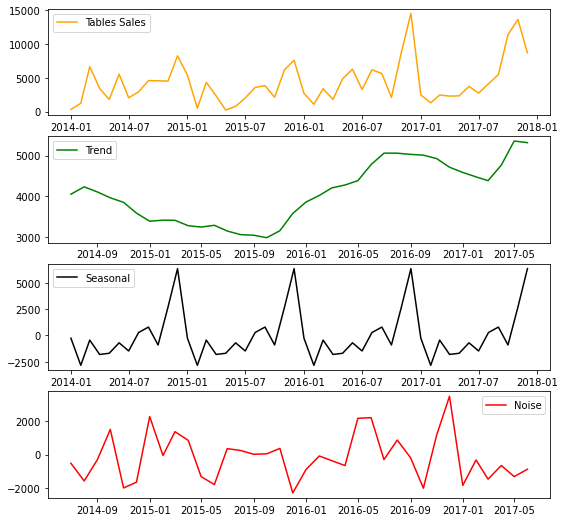

In [25]:
decompose_show(tables,trend4,seasonal4,residual4,"Tables Sales")

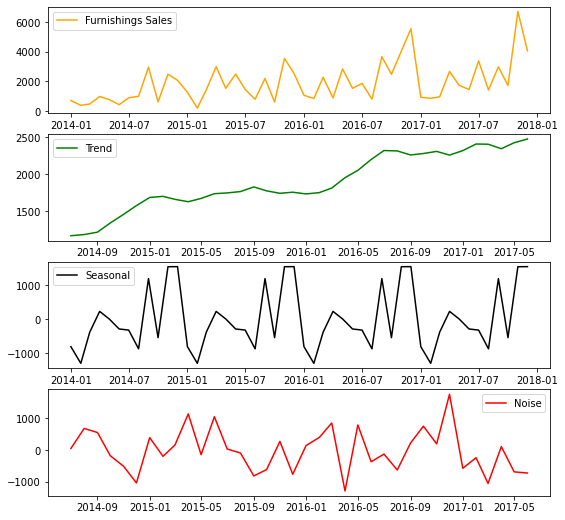

In [26]:
decompose_show(furnishings,trend5,seasonal5,residual5,"Furnishings Sales")

By visualizing all charts we can see there is presence of both trend and seasonality on the data.

#### Stationarity Check

In [27]:
#function for checking stationarity of data
def checkstationarity(data):
    pvalue=adfuller(data)[1]
    if pvalue<0.05:
        do='Data is stationary. Do model building.'
    else:
        do='Data is not stationary. Make data as stationary'
    return(do)

In [28]:
checkstationarity(furniture)

'Data is stationary. Do model building.'

In [29]:
checkstationarity(bookcases)

'Data is stationary. Do model building.'

In [30]:
checkstationarity(chairs)

'Data is stationary. Do model building.'

In [31]:
checkstationarity(tables)

'Data is stationary. Do model building.'

In [32]:
checkstationarity(furnishings)

'Data is stationary. Do model building.'

#### Plotting ACF and PACF

In [33]:
#function for plotting acf and pacf plots
def pqplot(data,lags=int):
    fig,ax=plt.subplots(1,2,figsize=(16,8))
    plot_acf(data,lags=lags,ax=ax[0])
    plot_pacf(data,lags=lags,ax=ax[1])
    plt.show()

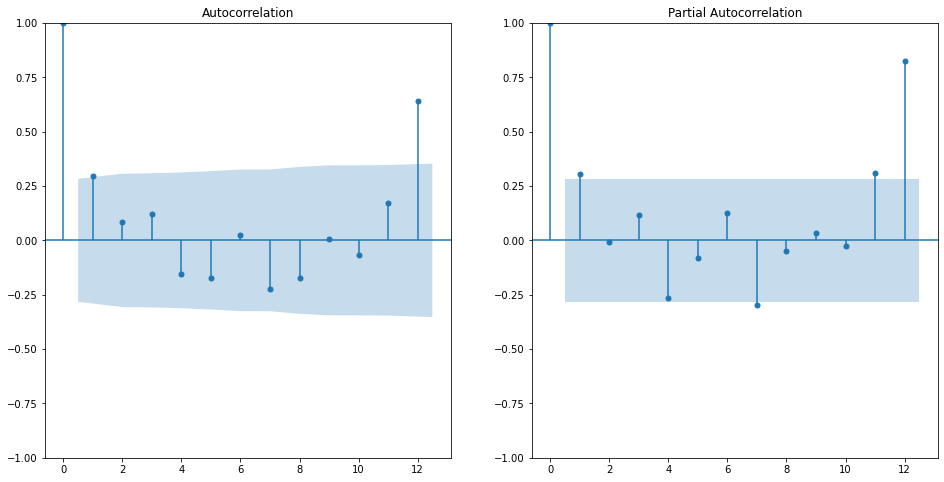

In [34]:
pqplot(furniture,12)

Here p value is 4 and q value is 1.

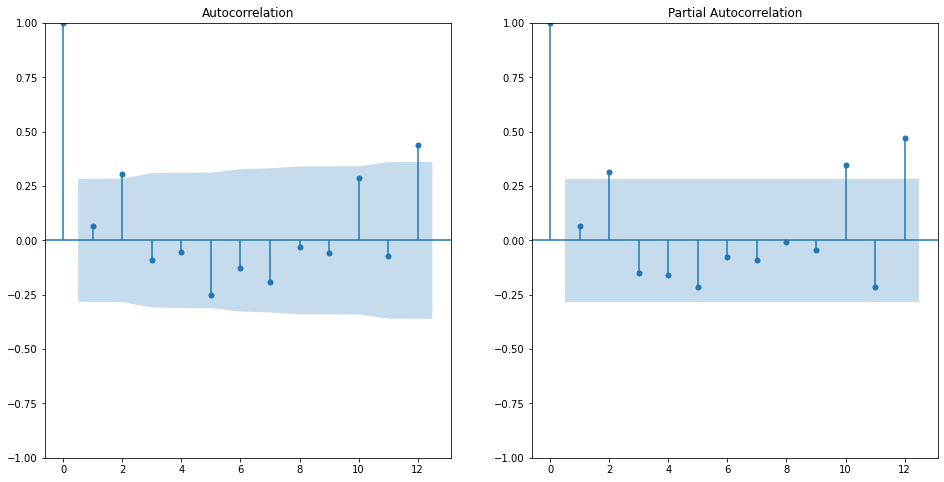

In [35]:
pqplot(bookcases,12)

Here p value is 3 and q value is 2.

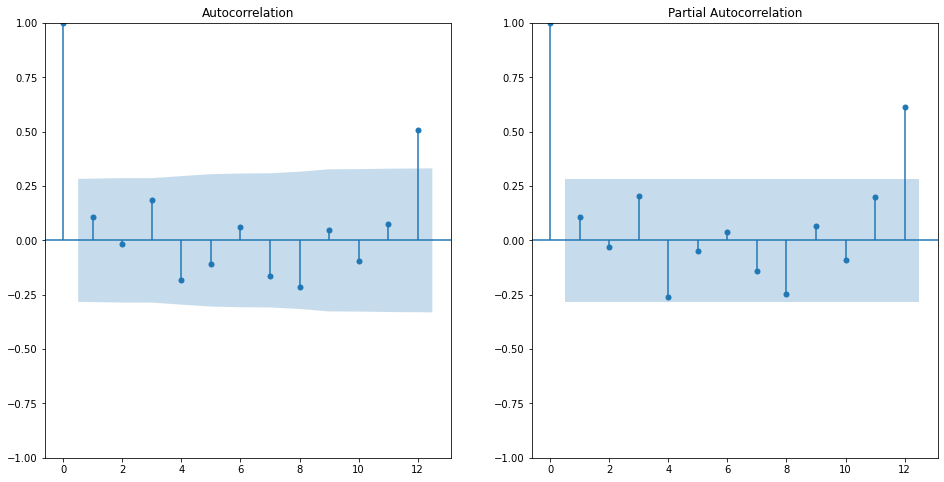

In [36]:
pqplot(chairs,12)

Here p value is 1 and q value is 1.

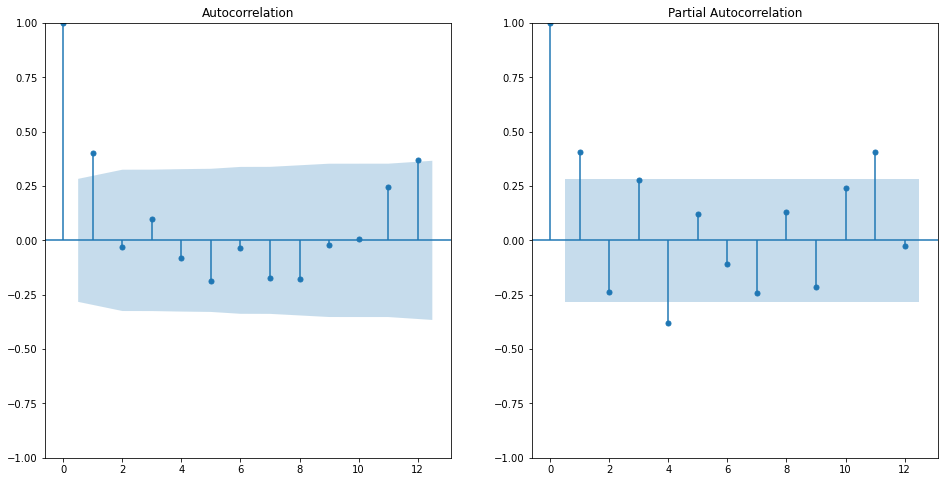

In [37]:
pqplot(tables,12)

Here p value is 3 and q value is 1.

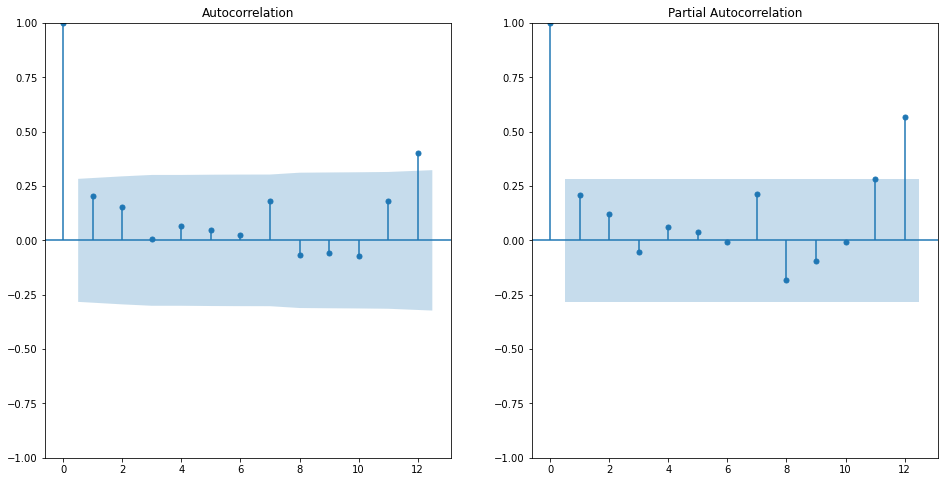

In [38]:
pqplot(furnishings,12)

Here p value is 2 and q value is 1.

#### Train Test Spliting

In [39]:
#function for splitting data
def split(data,split=0.7):
    num = int(split * len(data))
    train = data.iloc[:num]
    test = data.iloc[num:]
    return train,test

In [40]:
furniture_train,furniture_test=split(furniture)
bookcases_train,bookcases_test=split(bookcases,0.9)
chairs_train,chairs_test=split(chairs,0.9)
tables_train,tables_test=split(tables,0.9)
furnishings_train,furnishings_test=split(furnishings,0.9)

## Model Building

In [41]:
#user defined function to get optimum p&q values of sarima model
def sarima_values(data,a=2,b=2,d=12):
    values1=[]
    for p in range(a):
        for q in range(b):
            values1.append((p,0,q))
    values2=[]
    for p in range(a):
        for q in range(b):
            values2.append((p,0,q,d))            
    model=[]
    for i,j in zip(values1,values2):
            m=sm.tsa.statespace.SARIMAX(data,order=i,seasonal_order=(j)).fit()
            model.append(m)
    values1
    aic=[]
    bic=[]
    RMSE=[]
    for i in model[0:]:
        aic.append(i.aic)
        bic.append(i.bic)
        h=mean_squared_error(data,i.fittedvalues,squared=False)
        RMSE.append(h)
    x=min(aic)
    y=min(bic)
    z=min(RMSE)
    m=values1[aic.index(x)]
    n=values1[bic.index(y)]
    o=values1[RMSE.index(z)]
    return(m,n,o)

In [42]:
#user defined function to predict train data
def train_prediction(model,train,test):
    train_predictions = model.predict(0,len(train)-1)
    result=pd.DataFrame()
    result['Actual']=train
    result['Train_Predicted']=train_predictions
    return(result)

In [43]:
#user defined function to predict test data
def test_prediction(model,train,test):
    test_predictions = model.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True)
    result=pd.DataFrame()
    result['Actual']=test
    result['Test_Predicted']=test_predictions
    return(result)

### Furniture Data Model

In [44]:
sarima_values(furniture_train,4,1,12) #optimum p&q values of aic,bic & rmse

((3, 0, 0), (1, 0, 0), (3, 0, 0))

In [45]:
p=3; q=0; d=0
model1 = sm.tsa.statespace.SARIMAX(furniture_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit() #sarima model
model1.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   33
Model:             SARIMAX(3, 0, 0)x(3, 0, 0, 12)   Log Likelihood                -329.587
Date:                            Mon, 14 Nov 2022   AIC                            673.175
Time:                                    04:05:06   BIC                            683.650
Sample:                                01-01-2014   HQIC                           676.700
                                     - 09-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2994      0.273      1.096      0.273      -0.236       0.835
ar.L2          0.1006      0.240      0.418      0.676      -0.371       0.572
ar.L3          0.3857      0.233      1.657      0.098      -0.071       0.842
ar.S.L12       0.2810      1.626      0.173      0.863      -2.907       3.468
ar.S.L24       0.7746      0.339      2.288      0.022       0.111       1.438
ar.S.L36      -0.0918      2.029     -0.045      0.964      -4.068       3.885
sigma2      8.812e+06   1.33e-06   6.61e+12      0.000    8.81e+06    8.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.41   Prob(JB):                         0.97
Heteroskedasticity (H):               2.39   Skew:                            -0.01
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+28. Standard errors may be unstable.
"""

In [46]:
#getting train predictons
train_result1=train_prediction(model1,furniture_train,furniture_test)
train_result1.head(2)

Actual  Train_Predicted
Order Date                           
2014-01-01  6242.525         0.000000
2014-02-01  1839.658      4192.718538

In [47]:
#getting test predictions
test_result1=test_prediction(model1,furniture_train,furniture_test)
test_result1.head(2)

Actual  Test_Predicted
Order Date                            
2016-10-01  11872.5770    14270.233059
2016-11-01  31783.6288    25843.706222

In [48]:
#forecasting values
forecast1=model1.predict(len(furniture)-1,len(furniture)+12)

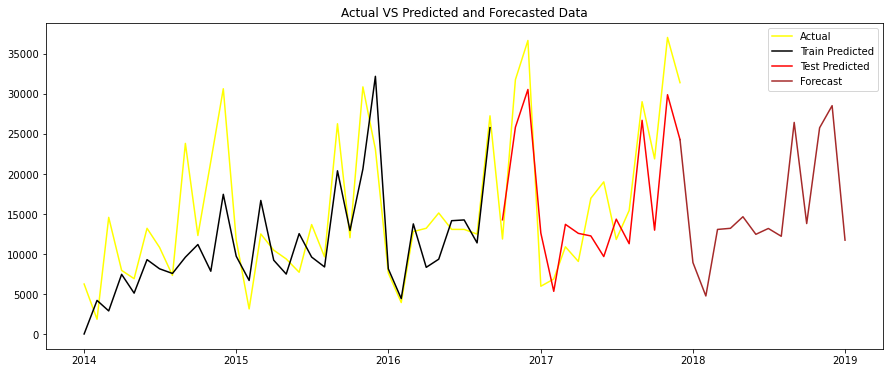

In [49]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Predicted and Forecasted Data')
plt.plot(furniture,label='Actual',color='yellow')
plt.plot(train_result1.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result1.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast1,label='Forecast',color='brown')
plt.legend();

Model has performed well in learning the trend and seasonality part.


As per the forecast furniture sales are going to have a dip in the near future.


In [50]:
#performance check
aic1=model1.aic
bic1=model1.bic
train_rmse1=mean_squared_error(train_result1.Actual, train_result1.Train_Predicted,squared=False)
test_rmse1=mean_squared_error(test_result1.Actual, test_result1.Test_Predicted,squared=False)

print('AIC :',aic1)
print('BIC :',bic1)
print('Train RMSE :',train_rmse1)
print('Test RMSE :',test_rmse1)

AIC : 673.1749302911811
BIC : 683.6504832214465
Train RMSE : 5883.281659915223
Test RMSE : 5567.943954124898


### Bookcase Data Model

In [51]:
sarima_values(bookcases_train,3,1,12) #optimum p&q values of aic,bic & rmse

((2, 0, 0), (1, 0, 0), (2, 0, 0))

In [52]:
p=2; q=0; d=0
model2 = sm.tsa.statespace.SARIMAX(bookcases_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit() #sarima model
model2.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   43
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -387.286
Date:                            Mon, 14 Nov 2022   AIC                            784.571
Time:                                    04:05:07   BIC                            793.377
Sample:                                01-01-2014   HQIC                           787.819
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2975      0.204      1.456      0.145      -0.103       0.698
ar.L2          0.3182      0.366      0.869      0.385      -0.399       1.036
ar.S.L12       0.4290      0.199      2.160      0.031       0.040       0.818
ar.S.L24       0.3508      0.290      1.208      0.227      -0.218       0.920
sigma2      3.053e+06   9.21e+05      3.314      0.001    1.25e+06    4.86e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                46.32
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             1.51
Prob(H) (two-sided):                  0.44   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
#getting train predictons
train_result2=train_prediction(model2,bookcases_train,bookcases_test)
train_result2.head(2)

Actual  Train_Predicted
Order Date                           
2014-01-01  1010.055          0.00000
2014-02-01     0.000        455.18731

In [54]:
#getting test predictions
test_result2=test_prediction(model2,bookcases_train,bookcases_test)
test_result2.head(2)

Actual  Test_Predicted
Order Date                          
2017-08-01   460.092     2739.934011
2017-09-01  3635.856     6825.143409

In [55]:
#forecasting values
forecast2=model2.predict(len(bookcases)-1,len(bookcases)+12)

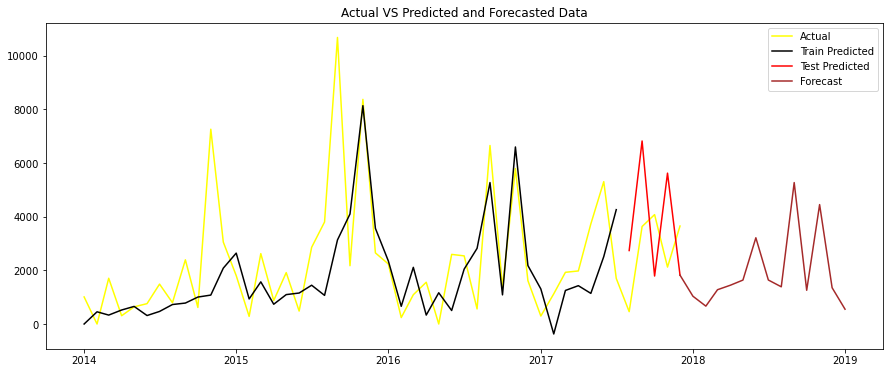

In [56]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Predicted and Forecasted Data')
plt.plot(bookcases,label='Actual',color='yellow')
plt.plot(train_result2.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result2.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast2,label='Forecast',color='brown')
plt.legend();

Model has performed well in learning the trend but not the seasonality part.

As per the forecast bookcase sales are going to have a slight dip after that it will have an increase in sales.


In [57]:
#performance check
aic2=model2.aic
bic2=model2.bic
train_rmse2=mean_squared_error(train_result2.Actual, train_result2.Train_Predicted,squared=False)
test_rmse2=mean_squared_error(test_result2.Actual, test_result2.Test_Predicted,squared=False)

print('AIC :',aic2)
print('BIC :',bic2)
print('Train RMSE :',train_rmse2)
print('Test RMSE :',test_rmse2)

AIC : 784.5714954487821
BIC : 793.3774960272499
Train RMSE : 1945.4202963788223
Test RMSE : 2692.3047233930456


### Chair Data Model

In [58]:
sarima_values(chairs_train,2,1,12) #optimum p&q values of aic,bic & rmse

((1, 0, 0), (1, 0, 0), (1, 0, 0))

In [59]:
p=1; q=0; d=0
model3 = sm.tsa.statespace.SARIMAX(chairs_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit() #sarima model
model3.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   43
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -415.729
Date:                            Mon, 14 Nov 2022   AIC                            837.457
Time:                                    04:05:08   BIC                            842.741
Sample:                                01-01-2014   HQIC                           839.406
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2738      0.177      1.546      0.122      -0.073       0.621
ar.S.L12       0.8761      0.047     18.664      0.000       0.784       0.968
sigma2      9.716e+06   2.83e-09   3.43e+15      0.000    9.72e+06    9.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.21   Prob(JB):                         0.64
Heteroskedasticity (H):               1.13   Skew:                            -0.30
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.89e+31. Standard errors may be unstable.
"""

In [60]:
#getting train predictons
train_result3=train_prediction(model3,chairs_train,chairs_test)
train_result3.head(2)

Actual  Train_Predicted
Order Date                           
2014-01-01  4187.700          0.00000
2014-02-01   190.458       1146.65845

In [61]:
#getting test predictions
test_result3=test_prediction(model3,chairs_train,chairs_test)
test_result3.head(2)

Actual  Test_Predicted
Order Date                           
2017-08-01   9419.014     4084.835407
2017-09-01  16911.669     9842.270598

In [62]:
#forecasting values
forecast3=model3.predict(len(chairs)-1,len(chairs)+12)

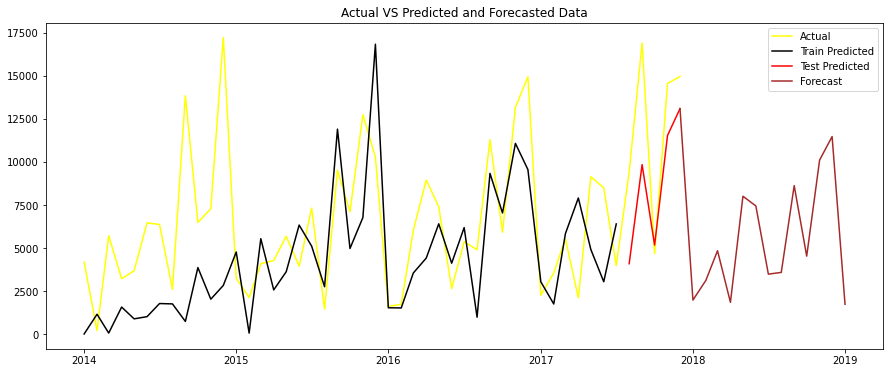

In [63]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Predicted and Forecasted Data')
plt.plot(chairs,label='Actual',color='yellow')
plt.plot(train_result3.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result3.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast3,label='Forecast',color='brown')
plt.legend();

Model has performed well in learning the trend and seasonality part.


We already saw that chairs have the highest sales in furniture category as per forecast there is a  dip in sales of chairs which has a major impact on overall furniture sales.

In [64]:
#performance check
aic3=model3.aic
bic3=model3.bic
train_rmse3=mean_squared_error(train_result3.Actual, train_result3.Train_Predicted,squared=False)
test_rmse3=mean_squared_error(test_result3.Actual, test_result3.Test_Predicted,squared=False)

print('AIC :',aic3)
print('BIC :',bic3)
print('Train RMSE :',train_rmse3)
print('Test RMSE :',test_rmse3)

AIC : 837.4571009974501
BIC : 842.7407013445307
Train RMSE : 4366.937872453831
Test RMSE : 4273.410465247434


### Table Data Model

In [65]:
sarima_values(tables_train,3,1,12) #optimum p&q values of aic,bic & rmse

((1, 0, 0), (1, 0, 0), (2, 0, 0))

In [66]:
p=1; q=0; d=0
model4 = sm.tsa.statespace.SARIMAX(tables_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit() #sarima model
model4.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   43
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -399.306
Date:                            Mon, 14 Nov 2022   AIC                            804.611
Time:                                    04:05:09   BIC                            809.895
Sample:                                01-01-2014   HQIC                           806.560
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5778      0.092      6.279      0.000       0.397       0.758
ar.S.L12       0.7104      0.159      4.473      0.000       0.399       1.022
sigma2      5.548e+06   1.58e+06      3.519      0.000    2.46e+06    8.64e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.46   Prob(JB):                         0.79
Heteroskedasticity (H):               1.45   Skew:                             0.22
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
#getting train predictons
train_result4=train_prediction(model4,tables_train,tables_test)
train_result4.head(2)

Actual  Train_Predicted
Order Date                          
2014-01-01   333.00         0.000000
2014-02-01  1256.22       192.774996

In [68]:
#getting test predictions
test_result4=test_prediction(model4,tables_train,tables_test)
test_result4.head(2)

Actual  Test_Predicted
Order Date                          
2017-08-01  4137.738     4661.612376
2017-09-01  5498.177     4152.867479

In [69]:
#forecasting values
forecast4=model4.predict(len(tables)-1,len(tables)+12)

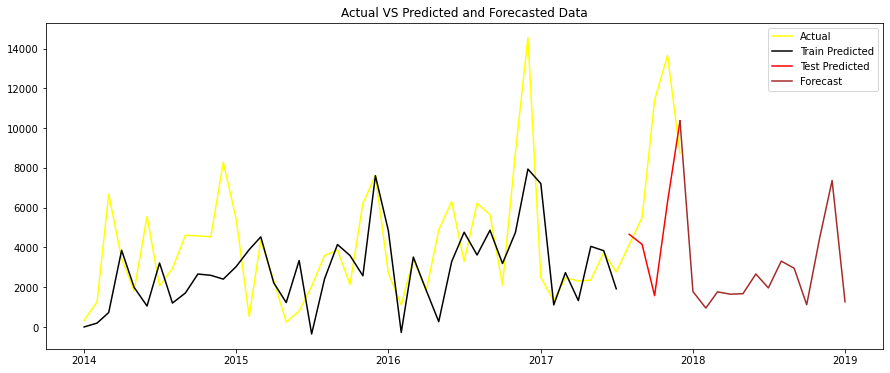

In [70]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Predicted and Forecasted Data')
plt.plot(tables,label='Actual',color='yellow')
plt.plot(train_result4.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result4.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast4,label='Forecast',color='brown')
plt.legend();

Model has performed well in learning the trend and seasonality part.

Tables have a major impact on furniture sales next to chairs thereby as per forecast tables sales are also going to have a dip which will impact the overall sales.

In [71]:
#performance check
aic4=model4.aic
bic4=model4.bic
train_rmse4=mean_squared_error(train_result4.Actual, train_result4.Train_Predicted,squared=False)
test_rmse4=mean_squared_error(test_result4.Actual, test_result4.Test_Predicted,squared=False)

print('AIC :',aic4)
print('BIC :',bic4)
print('Train RMSE :',train_rmse4)
print('Test RMSE :',test_rmse4)

AIC : 804.6113135044275
BIC : 809.8949138515081
Train RMSE : 2612.7418393744
Test RMSE : 5585.02626618427


### Furnishing Data Model

In [72]:
sarima_values(furnishings_train,2,1,12) #optimum p&q values of aic,bic & rmse

((1, 0, 0), (1, 0, 0), (1, 0, 0))

In [73]:
p=1; q=0; d=0
model5 = sm.tsa.statespace.SARIMAX(furnishings_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit() #sarima model
model5.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   43
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -368.835
Date:                            Mon, 14 Nov 2022   AIC                            743.670
Time:                                    04:05:10   BIC                            748.953
Sample:                                01-01-2014   HQIC                           745.618
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5114      0.139      3.678      0.000       0.239       0.784
ar.S.L12       0.6107      0.175      3.487      0.000       0.268       0.954
sigma2       1.44e+06   3.53e+05      4.079      0.000    7.48e+05    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.97   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.00   Prob(JB):                         0.81
Heteroskedasticity (H):               3.62   Skew:                             0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
#getting train predictons
train_result5=train_prediction(model5,furnishings_train,furnishings_test)
train_result5.head(2)

Actual  Train_Predicted
Order Date                         
2014-01-01  711.77         0.000000
2014-02-01  392.98       364.216461

In [75]:
#getting test predictions
test_result5=test_prediction(model5,furnishings_train,furnishings_test)
test_result5.head(2)

Actual  Test_Predicted
Order Date                          
2017-08-01  1425.030     1641.533505
2017-09-01  2982.504     2822.795979

In [76]:
#forecasting values
forecast5=model5.predict(len(furnishings)-1,len(furnishings)+12)

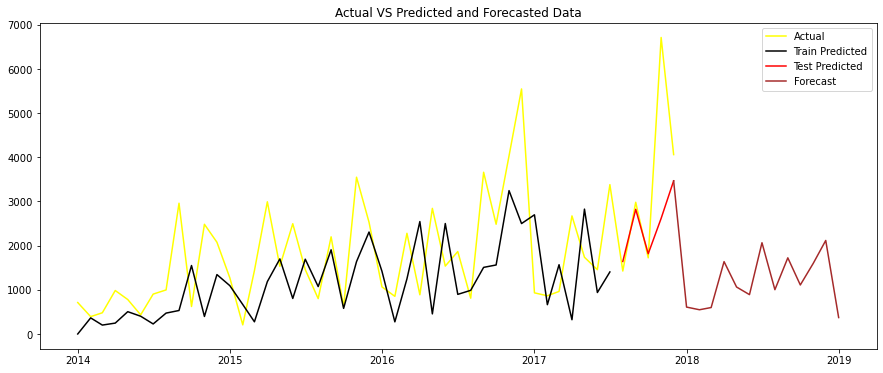

In [77]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Predicted and Forecasted Data')
plt.plot(furnishings,label='Actual',color='yellow')
plt.plot(train_result5.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result5.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast5,label='Forecast',color='brown')
plt.legend();

Model has performed well in learning the seasonality but not the trend part.

As per the forecast furnishing sales are going to have a slight dip after that it will have an increase in sales.

In [78]:
#performance check
aic5=model5.aic
bic5=model5.bic
train_rmse5=mean_squared_error(train_result5.Actual, train_result5.Train_Predicted,squared=False)
test_rmse5=mean_squared_error(test_result5.Actual, test_result5.Test_Predicted,squared=False)

print('AIC :',aic5)
print('BIC :',bic5)
print('Train RMSE :',train_rmse5)
print('Test RMSE :',test_rmse5)

AIC : 743.6697790228257
BIC : 748.9533793699063
Train RMSE : 1248.0125845866123
Test RMSE : 1855.5862332765214


## Conclusion

Furniture category has four categories of items.

Chairs and Tables hold the majority of sales within it.

Thereby from the forecast we saw there is an upcoming dip in both the sales of chairs and tables.

It has a direct impact on overall sales of furniture which we saw on furniture sales forecast.

Thereby immediate measures are required to be taken by the business to handle upcoming bear trend.
